<a href="https://colab.research.google.com/github/shreyab375/Deep-Learning/blob/main/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion



In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
!unzip gdrive/MyDrive/CNN_assignment

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

In [5]:
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [7]:
#Parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Train and Validation split: 80% train and 20% validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    batch_size = batch_size,
    subset = 'training',
    validation_split = 0.2,
    image_size = (img_height, img_width),

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    batch_size = batch_size,
    subset = 'validation',
    validation_split = 0.2,
    image_size = (img_height, img_width),
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
class_names = train_ds.class_names

In [11]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

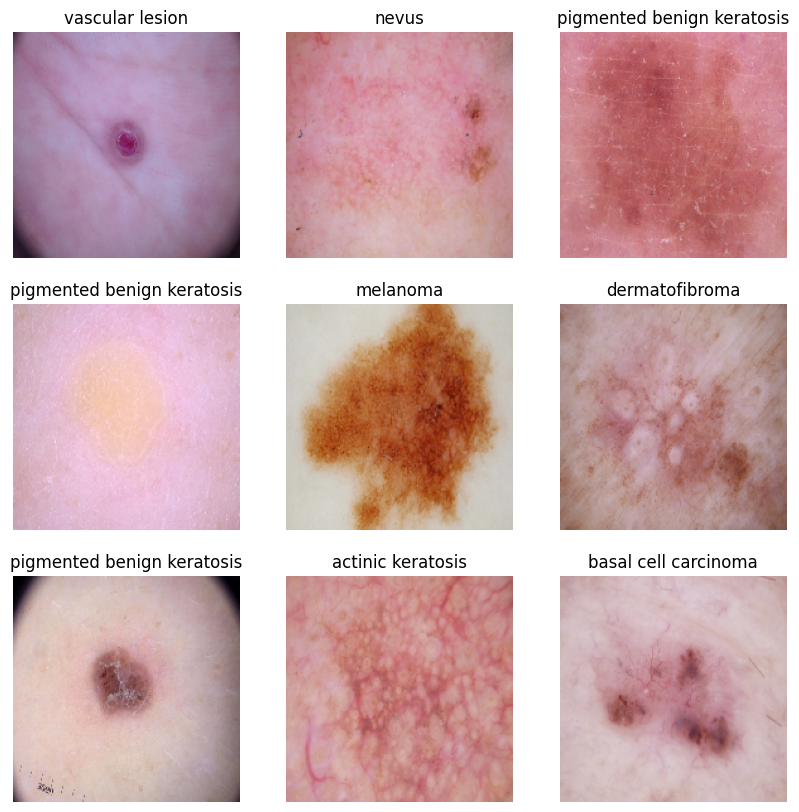

In [12]:
#Visualizing
plt.figure(figsize = (10,10))
#.take(1): This method is used to create a new dataset that contains a specified number of elements from the original dataset. In this case, take(1) is used to take only one element from the train_ds dataset.
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [13]:
# Optimizing the performance
AUTOTUNE = tf.data.experimental.AUTOTUNE #When set to AUTOTUNE, TensorFlow will automatically adjust the degree of parallelism dynamically based on available CPU and memory resources to optimize performance.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#.cache(): This operation caches the elements of the dataset in memory or on disk after they are loaded for the first time. Subsequent iterations through the dataset will use the cached data, leading to faster data access.
#.shuffle(1000): This operation shuffles the elements of the dataset with a buffer size of 1000. Shuffling the data helps in randomizing the order of the examples during training, preventing the model from learning spurious patterns based on the order of the data.
#prefetch(buffer_size=AUTOTUNE): This operation prefetches elements from the dataset into memory, overlapping the preprocessing and model execution stages. By prefetching data, TensorFlow can efficiently load and process the next batch of data while the current batch is being used for training, reducing the training time.
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE): Similarly, this line applies caching and prefetching operations to the validation dataset val_ds. Caching and prefetching help ensure that both training and validation datasets are efficiently processed during training, leading to improved training speed and resource utilization.

In [14]:
#Creating the model
num_classes = 9

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3, padding ='same', activation ='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3, padding ='same', activation ='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3, padding ='same', activation ='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation ='relu'),
    layers.Dense(num_classes),
])

In [15]:
model.compile(optimizer='adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
# Training the Model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 75ms/step - loss: 2.0996 - accuracy: 0.1981 - val_loss: 1.9954 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8749 - accuracy: 0.3181 - val_loss: 1.7253 - val_accuracy: 0.3356
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6748 - accuracy: 0.3990 - val_loss: 1.5706 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5293 - accuracy: 0.4637 - val_loss: 1.6065 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4527 - accuracy: 0.4911 - val_loss: 1.5191 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3594 - accuracy: 0.5273 - val_loss: 1.5240 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2526 - accuracy: 0.5525 - val_loss: 1.4107 - val_accuracy: 0.5369
Epoch 8/20
5

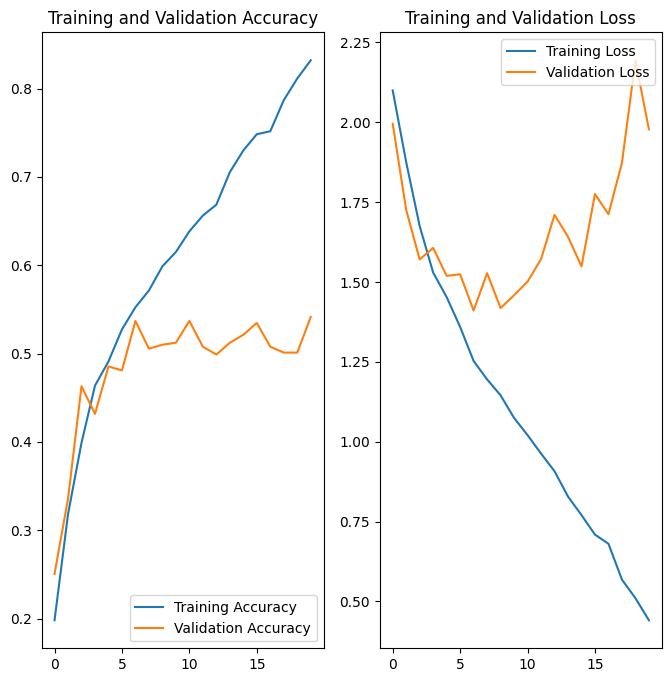

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# data Augmentation
data_aug = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

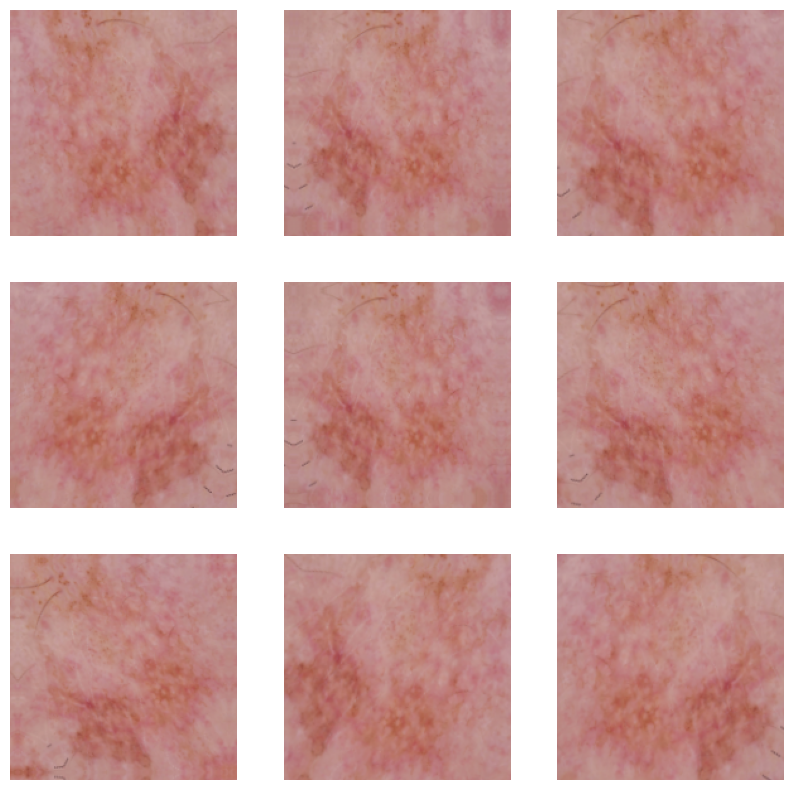

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_aug(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
#Create the Model Again
model = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 33ms/step - loss: 2.1440 - accuracy: 0.2271 - val_loss: 1.9345 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7712 - accuracy: 0.3588 - val_loss: 1.6042 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5830 - accuracy: 0.4302 - val_loss: 1.6819 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5681 - accuracy: 0.4442 - val_loss: 1.5500 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4988 - accuracy: 0.4565 - val_loss: 1.5169 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4536 - accuracy: 0.4838 - val_loss: 1.5424 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4311 - accuracy: 0.4972 - val_loss: 1.4016 - val_accuracy: 0.5414
Epoch 8/20
56

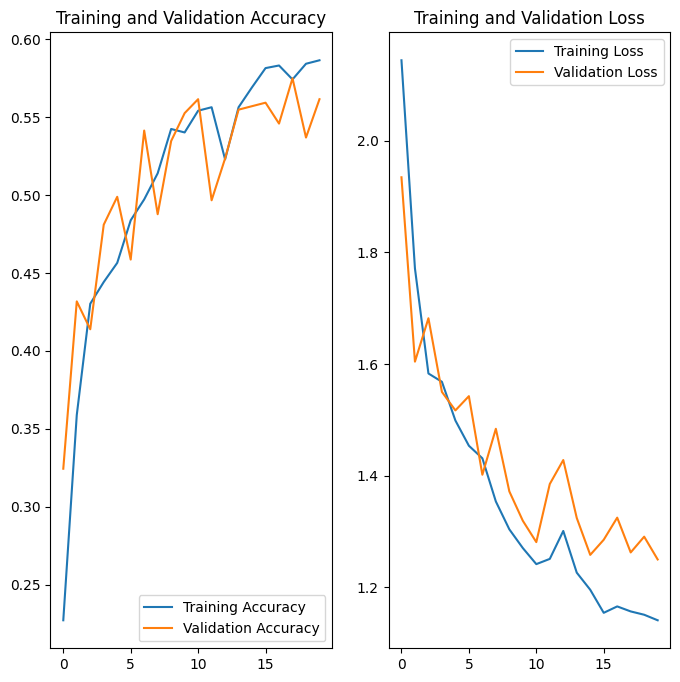

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [32]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,nevus
2235,Skin cancer ISIC The International Skin Imagin...,nevus
2236,Skin cancer ISIC The International Skin Imagin...,nevus
2237,Skin cancer ISIC The International Skin Imagin...,nevus


No charts were generated by quickchart


Class=0, n=114 (5.092%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=5, n=462 (20.634%)
Class=8, n=139 (6.208%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)


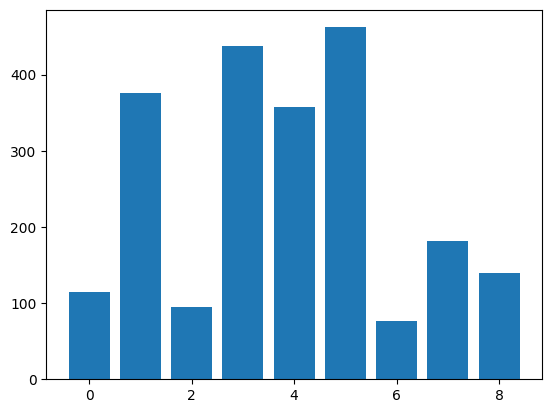

In [33]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

This code snippet is used to augment image data for each class in a training dataset to address class imbalance and enhance model generalization. Here's a breakdown of what it does:

Importing Necessary Libraries: The code imports the Augmentor library, which is a Python package used for image augmentation.

Defining the Path to the Training Dataset: It specifies the path to the directory containing the training dataset. Each subdirectory within this directory represents a different class of images.

Image Augmentation Loop: For each class in the dataset (class_names), the code creates an instance of the Pipeline class from Augmentor.

Augmentation Operations: Within each pipeline (p), it specifies augmentation operations to be applied to the images. In this case, rotation is applied with a probability of 70%, allowing for a maximum left rotation of 10 degrees and a maximum right rotation of 10 degrees.

Sampling: It generates augmented samples by calling the sample method on the pipeline. This method specifies the number of augmented images to be generated per class. In this case, 500 augmented samples are generated for each class.

In [35]:
!pip install Augmentor

In [36]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781774137A00>: 100%|██████████| 500/500 [00:19<00:00, 25.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78177414F8E0>: 100%|██████████| 500/500 [00:17<00:00, 29.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x781774107B80>: 100%|██████████| 500/500 [00:14<00:00, 34.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x781774143EE0>: 100%|██████████| 500/500 [01:23<00:00,  5.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x78178438A800>: 100%|██████████| 500/500 [01:09<00:00,  7.22 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7817741AEF20>: 100%|██████████| 500/500 [00:14<00:00, 34.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7817843A9900>: 100%|██████████| 500/500 [00:36<00:00, 13.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78177412B280>: 100%|██████████| 500/500 [00:14<00:00, 33.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7817843A8790>: 100%|██████████| 500/500 [00:14<00:00, 34.42 Samples/s]


In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [38]:
#joining to the original data
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_566a24bc-6c68-482e-9df1-64ebe224c2c4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_17c51e09-2af4-4123-858e-ef79abdaaf21.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_14b9fe9f-a602-479a-be1e-8f94dc0a6396.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_b70dcba5-203c-4c42-89a0-9faa8e57a1ef.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_5bf02be0-a3fb-496d-a6a1-8f5826082227.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-41-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [43]:
batch_size = 32
img_height = 180
img_width = 180

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 32s 56ms/step - loss: 1.9162 - accuracy: 0.2520 - val_loss: 1.4894 - val_accuracy: 0.4603
Epoch 2/20
169/169 [==============================] - 5s 27ms/step - loss: 1.4157 - accuracy: 0.4677 - val_loss: 1.4812 - val_accuracy: 0.4633
Epoch 3/20
169/169 [==============================] - 4s 26ms/step - loss: 1.2042 - accuracy: 0.5508 - val_loss: 1.1011 - val_accuracy: 0.5716
Epoch 4/20
169/169 [==============================] - 5s 28ms/step - loss: 1.0457 - accuracy: 0.6207 - val_loss: 0.9946 - val_accuracy: 0.6399
Epoch 5/20
169/169 [==============================] - 4s 26ms/step - loss: 0.8733 - accuracy: 0.6830 - val_loss: 0.9293 - val_accuracy: 0.6845
Epoch 6/20
169/169 [==============================] - 4s 26ms/step - loss: 0.7455 - accuracy: 0.7339 - val_loss: 0.8906 - val_accuracy: 0.7075
Epoch 7/20
169/169 [==============================] - 5s 29ms/step - loss: 0.6361 - accuracy: 0.7767 - val_loss: 0.8527 - val_accuracy: 0.705

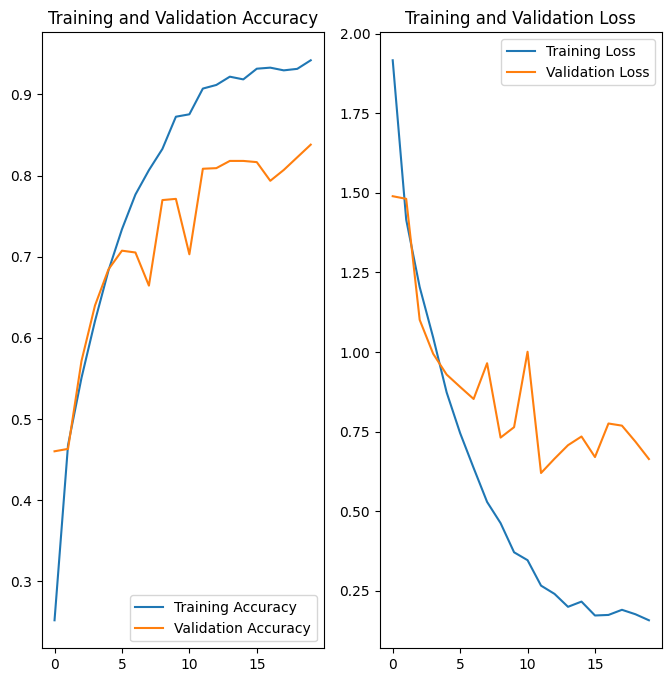

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()